# Goal

The main goal of this EDA is to identify which columns in the input files are closely related to the customers activity. This information will help us to perform **feature engineering** and also help us to design and implement a predictive model to optimize free customers conversion to paid members.


# Preparation
To perform this EDA, I have generated customer's activity based on the the provided input files. Please refer to the **STEP1 Transformation Pipeline** Notebook to understand how I enhanced customer's activity dataset adding `LASTUSED` column. The `LASTUSED` column will represent the number of days since the customer has used the system.


# Results of the EDA
Found the following insights as a result of this EDA. For detailed analysis, please check the other sections in this document:

1. The customers activity data is stationary data. That is the current week's customer activity is independent of the last week's customer's activity. So we can safely apply traditional Machine Learning models (which assume independence between the dataset's observations)

2. The marketing campaigns for the months of Jan, Feb and June are very successful, while the campaign for Nov and Dec months are not very successful. Is this due to availability/unavailability of marketing budget?

3. The 5th week of the year has highest number of conversions. 

4. There is a strong correlation between the following columns:
```
  ACTIONS_CRM_CONTACTS <-> USERS_CRM_CONTACTS (0.81)
  ACTIONS_CRM_COMPANIES <-> USERS_CRM_COMPANIES (0.72)
  ACTIONS_CRM_DEALS <-> USERS_CRM_DEALS (0.75)
  ACTIONS_EMAIL <-> USERS_EMAIL (0.68)
  USERS_CRM_COMPANIES <-> USERS_CRM_DEALS (0.6)
```
These correlated columns should be combined to reduce the dimensionality. A good option is to use `ACTIONS/USER` metric or use PCA (Principal Component Analysis) to reduce the dimensions.

5. As the values of the following numeric columns increas, the probability of the activity belonging to paid members increases:
```
    ACTIONS_CRM_CONTACTS
    ACTIONS_CRM_COMPANIES
    ACTIONS_CRM_DEALS
    ACTIONS_EMAIL
    USERS_CRM_COMPANIES
```

6. As the usage of the system (by a customer) decreases, the probability that the inactivity belonging to a FREE customer significantly increases. In fact if a customer does not use the system for more than 3 weeks, then there is 99% probability that the customer is a FREE tier member. Therefore the `LASTUSED` column plays an important role to determine the success of a marketing campaign.

7. Looks like the null values in `ALEXA_RANK` column were represented by a very big value 16000001. This column is not very important to find the customer's engagement with the system. The membership type is indifferent for various values of the `ALEXA_RANK`.

8. The `INDUSTRY` categorical column has ~65% of NULL values. Therefore this column should be ignored from further analysis.

9. The `EMPLOYEE_RANGE` categorical column has 10% null values. I am ignoring this column also right now, to make the analysis simple. I will revesit this later, if I am given time.

# Next Steps

1. Scale the numeric data using Std. Scaler
2. Apply PCA using the following columns:
```
    ACTIONS_CRM_CONTACTS
    ACTIONS_CRM_COMPANIES
    ACTIONS_CRM_DEALS
    ACTIONS_EMAIL
    USERS_CRM_COMPANIES
```
3. Apply clustering (K Means) on the transformed data.
4. Select the optimal number of customers.
5. For each cluster determine the probability of having a PREMIUM Customer, BEFORE-PREMIUM customer and FREE customer.
6. This clustering will help us to determine potential customers whose system usage activity matches to the current paid customers and could respond positively to a marketing campaign. Another cool byproduct of clustering is, we can identify PAID customers who could churn away from the business. If a paid member falls in a cluster that contains all FREE members, then it is time to approach that customer proactively before they cancel their PAID membership.

# Detailed EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from util import transform_data, cat_to_num_plot
import util

In [2]:
# file paths
customers_file = "./customers (4).csv"
non_customers_file = "./noncustomers (4).csv"
activity_file = "./usage_actions (4).csv"


In [3]:
# Read individual files
customers_df = pd.read_csv(customers_file)
non_customers_df = pd.read_csv(non_customers_file)

# Read the combined activity file. Check STEP 1 Notebook
all_activity_df = util.transform_data(customers_file,non_customers_file,activity_file)

In [4]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CLOSEDATE       200 non-null    object 
 1   MRR             200 non-null    float64
 2   ALEXA_RANK      200 non-null    int64  
 3   EMPLOYEE_RANGE  198 non-null    object 
 4   INDUSTRY        71 non-null     object 
 5   id              200 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 9.5+ KB


In [5]:
(1-71/200)*100

64.5

* we have 65% null in INDUSTRY. Let us ignore that from further analysis.

In [6]:
customers_df.head()

,CLOSEDATE,MRR,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,id
0,2019-06-20,290.00,309343,201 to 1000,Other,199
1,2019-03-22,392.54,16000001,51 to 200,NaN,147
2,2020-01-08,-61.15,60502,1001 to 10000,HIGHER_EDUCATION,118
3,2019-09-19,400.00,3575321,201 to 1000,CONSUMER_SERVICES,126
4,2019-01-27,209.98,273063,26 to 50,Technology - Software,174


In [7]:
all_activity_df.head()

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
0,199,309343.0,201 to 1000,Other,290.0,2019-01-07,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0,BEFORE-PREMIUM
1,199,309343.0,201 to 1000,Other,290.0,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM
2,199,309343.0,201 to 1000,Other,290.0,2019-01-21,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0,BEFORE-PREMIUM
3,199,309343.0,201 to 1000,Other,290.0,2019-01-28,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0,BEFORE-PREMIUM
4,199,309343.0,201 to 1000,Other,290.0,2019-02-04,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0,BEFORE-PREMIUM


## Is this Time Series Data?

* Choose 3 random PAID IDs, and examine their activity plots

In [8]:
customers_df["id"]

0      199
1      147
2      118
3      126
4      174
      ... 
195    112
196     97
197     14
198    160
199     31
Name: id, Length: 200, dtype: int64

In [9]:

# select 199, 31 and 174 customer IDs
customer_A = 199
customer_B = 31
customer_C = 147

<AxesSubplot: title={'center': 'Customer 199 Activity'}, xlabel='DATE'>

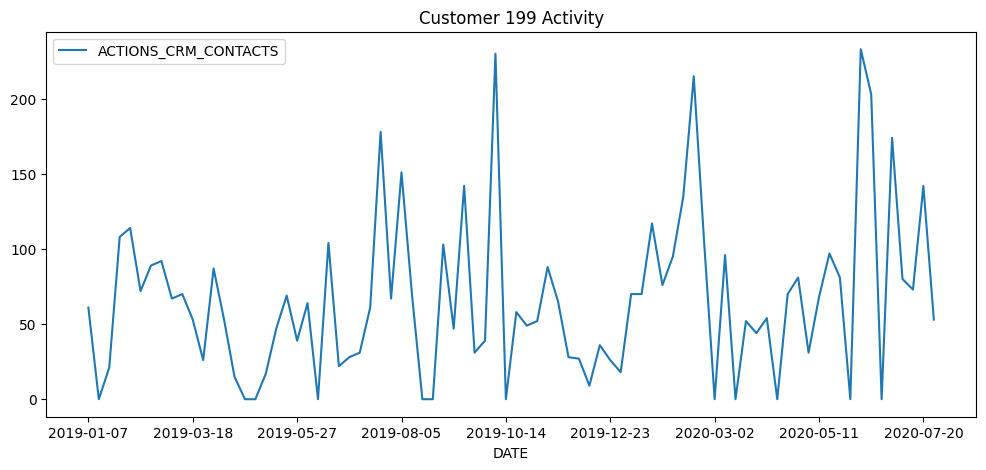

In [10]:
all_activity_df[all_activity_df["id"]==customer_A].sort_values(by="DATE").plot(x='DATE', 
                                                                               y="ACTIONS_CRM_CONTACTS", 
                                                                               figsize=(12,5), 
                                                                               title=f"Customer {customer_A} Activity")

<AxesSubplot: title={'center': 'Customer 31 Activity'}, xlabel='DATE'>

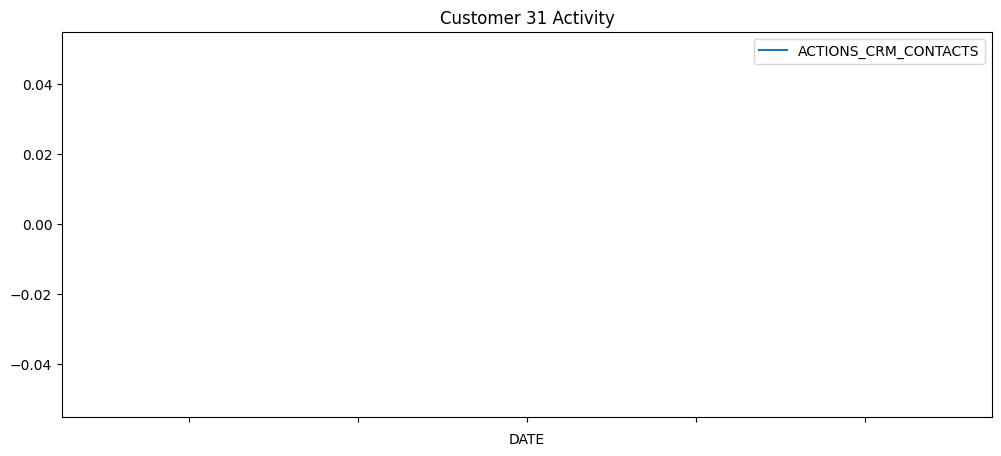

In [11]:
all_activity_df[all_activity_df["id"]==customer_B].sort_values(by="DATE").plot(x='DATE', 
                                                                               y="ACTIONS_CRM_CONTACTS", 
                                                                               figsize=(12,5), 
                                                                               title=f"Customer {customer_B} Activity")

<AxesSubplot: title={'center': 'Customer 147 Activity'}, xlabel='DATE'>

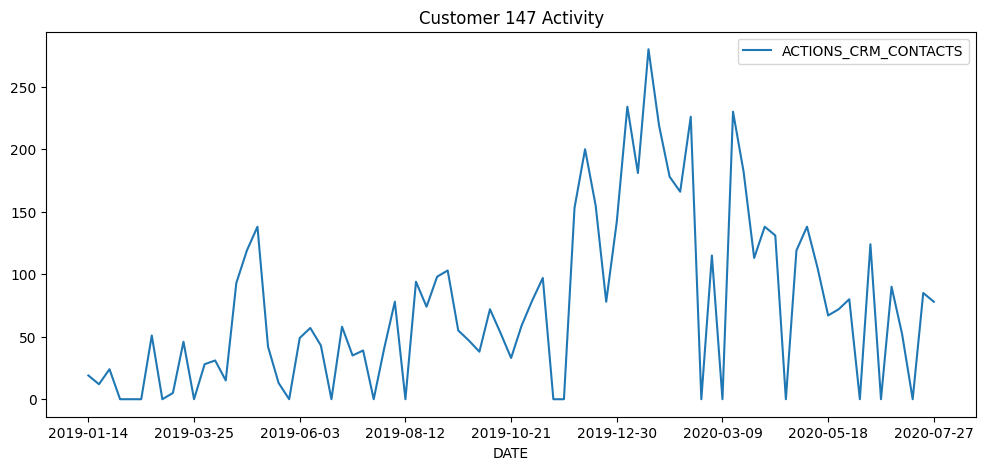

In [12]:
all_activity_df[all_activity_df["id"]==customer_C].sort_values(by="DATE").plot(x='DATE', 
                                                                               y="ACTIONS_CRM_CONTACTS", 
                                                                               figsize=(12,5), 
                                                                               title=f"Customer {customer_C} Activity")

### Inference
* This is not a time-series data. The pattern is pretty stationary
* Also for one of the customers (paid), we do not have any activity associated.

In [13]:
len(all_activity_df[(all_activity_df["MEMBERSHIPTYPE"] == 'PREMIUM')]["id"].unique())

188

* Out of 200 customers (paid members), 12 members activity is missing in the activity file.
* Is it a bug in the data collection?

## Which months campaign are successful?
Based on the number of sign-ups

<AxesSubplot: xlabel='MONTH', ylabel='CONVERSIONS'>

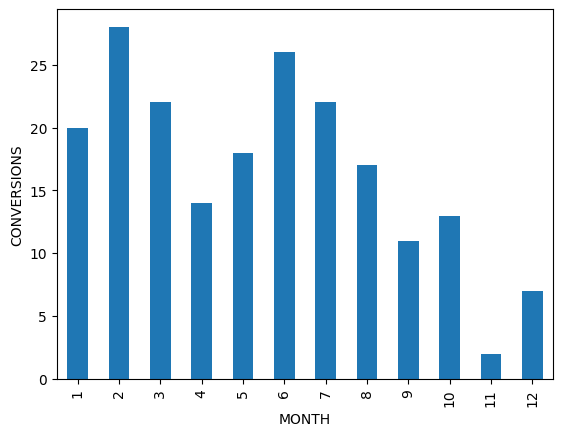

In [14]:
_,months,_ = zip(*customers_df['CLOSEDATE'].str.split("-"))
customers_df['MONTH'] = months
customers_df['MONTH'] = customers_df['MONTH'].astype('int')
customers_df['MONTH'].value_counts().sort_index().plot.bar(xlabel="MONTH", ylabel="CONVERSIONS")


### Inference
* The marketing campaigns are pretty successful during Feb, June, July, but least successful in Nov months.
* This could be due to low marketing efforts in Nov/Dec time or the customers are not very responsive due to the end of year (may be no more budget is available) to buy paid membership.

### Which weeks campaigs are successful?

<AxesSubplot: xlabel='WEEK', ylabel='CONVERSIONS'>

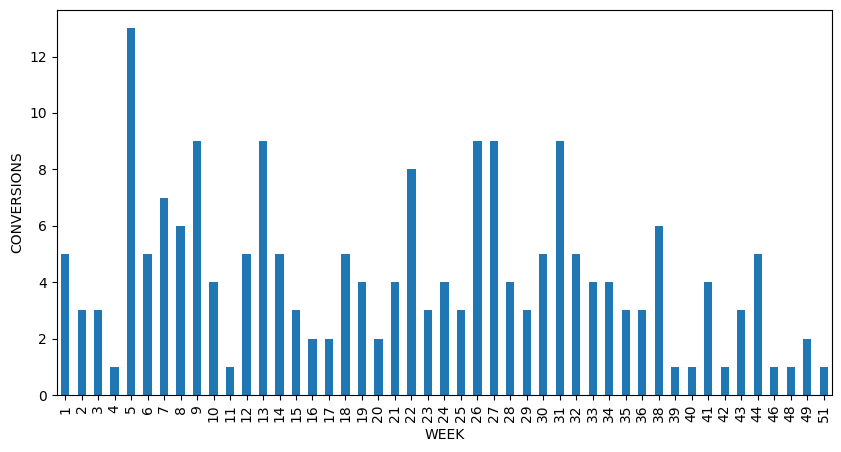

In [15]:
customers_df['WEEK']= pd.to_datetime(customers_df.CLOSEDATE, format="%Y-%m-%d").dt.isocalendar().week
customers_df['WEEK'].value_counts().sort_index().plot.bar(xlabel="WEEK", ylabel="CONVERSIONS", figsize=(10,5))

### Inference
Looks like the campaigns in January are very successful, since a large number of sign-ups have happened in week-5.

## Check if the correlation between the numeric columns in customer activity data

We have the following columns that represents some of the customer activities:

```
ACTIONS_CRM_CONTACTS
ACTIONS_CRM_COMPANIES
ACTIONS_CRM_DEALS
ACTIONS_EMAIL
USERS_CRM_CONTACTS 
USERS_CRM_COMPANIES
USERS_CRM_DEALS
USERS_EMAIL
LASTUSED
```

Let us determine how these columns are correlated to each other



,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL
ACTIONS_CRM_CONTACTS,1.000000,0.191725,0.172646,0.158145,0.816679,0.230356,0.245914,0.219402
ACTIONS_CRM_COMPANIES,0.191725,1.000000,0.132776,0.169348,0.320979,0.726073,0.374835,0.266234
ACTIONS_CRM_DEALS,0.172646,0.132776,1.000000,0.285293,0.367785,0.265669,0.750390,0.384656
ACTIONS_EMAIL,0.158145,0.169348,0.285293,1.000000,0.305432,0.298753,0.322997,0.684635
USERS_CRM_CONTACTS,0.816679,0.320979,0.367785,0.305432,1.000000,0.488159,0.535979,0.429396
USERS_CRM_COMPANIES,0.230356,0.726073,0.265669,0.298753,0.488159,1.000000,0.590140,0.447004
USERS_CRM_DEALS,0.245914,0.374835,0.750390,0.322997,0.535979,0.590140,1.000000,0.474619
USERS_EMAIL,0.219402,0.266234,0.384656,0.684635,0.429396,0.447004,0.474619,1.000000


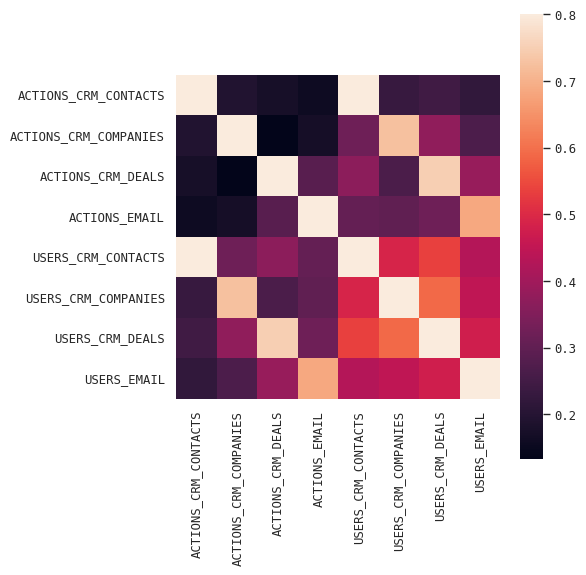

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="paper", font="monospace")

# Load the datset of correlations between cortical brain networks
#df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)
corrmat = all_activity_df[['ACTIONS_CRM_CONTACTS', 'ACTIONS_CRM_COMPANIES', 'ACTIONS_CRM_DEALS',
       'ACTIONS_EMAIL', 'USERS_CRM_CONTACTS', 'USERS_CRM_COMPANIES',
       'USERS_CRM_DEALS', 'USERS_EMAIL']].corr()
 
display(corrmat)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

f.tight_layout()

### Inference
* We can see that the following columns are positively correlated to each other:
```
    ACTIONS_CRM_CONTACTS <-> USERS_CRM_CONTACTS (0.81)
    ACTIONS_CRM_COMPANIES <-> USERS_CRM_COMPANIES (0.72)
    ACTIONS_CRM_DEALS <-> USERS_CRM_DEALS (0.75)
    ACTIONS_EMAIL <-> USERS_EMAIL (0.68)
    USERS_CRM_COMPANIES <-> USERS_CRM_DEALS (0.6)
```

* We should either combine the corresponding columns (like ACTIONS/USER) or apply PCA (Principal Component Analysis) and reduce the dimensions
    
    
    

## Analyzing `ACTIONS_CRM_CONTACTS`

In [17]:
all_activity_df['ACTIONS_CRM_CONTACTS'].value_counts()

0.0       130111
1.0         1809
2.0         1061
3.0          730
4.0          573
           ...  
338.0          1
420.0          1
587.0          1
445.0          1
2503.0         1
Name: ACTIONS_CRM_CONTACTS, Length: 1164, dtype: int64

We have a lot of 0 values in this dataset, and also quite large values. The values are ranging between 0 to 2503.



### Given that the ACTIONS_CRM_CONTACTS is 0, what is the probability distribution for MEMBERSHIPTYPE?

FREE              96.734327
BEFORE-PREMIUM     1.356534
PREMIUM            1.909139
Name: MEMBERSHIPTYPE, dtype: float64


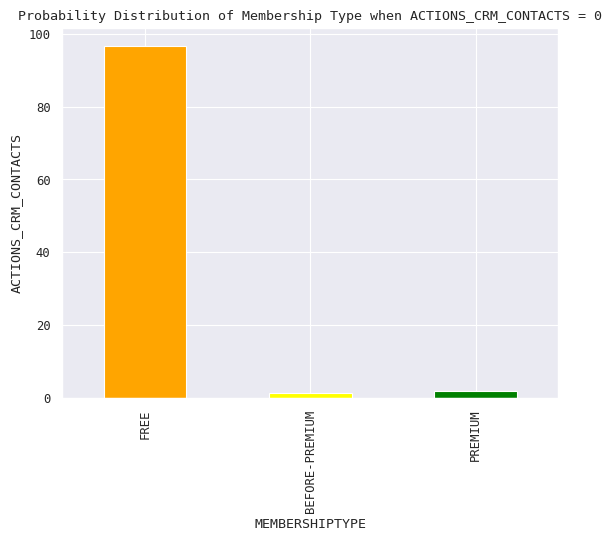

In [18]:

util.activity_vs_membership_plot(all_activity_df[all_activity_df['ACTIONS_CRM_CONTACTS'] == 0], 
                            'MEMBERSHIPTYPE', 
                            'ACTIONS_CRM_CONTACTS', 'Probability Distribution of Membership Type when ACTIONS_CRM_CONTACTS = 0')


### Given that the ACTIONS_CRM_CONTACTS > 50, what is the probability distribution for MEMBERSHIPTYPE?

FREE              25.229872
BEFORE-PREMIUM    17.111460
PREMIUM           57.658668
Name: MEMBERSHIPTYPE, dtype: float64


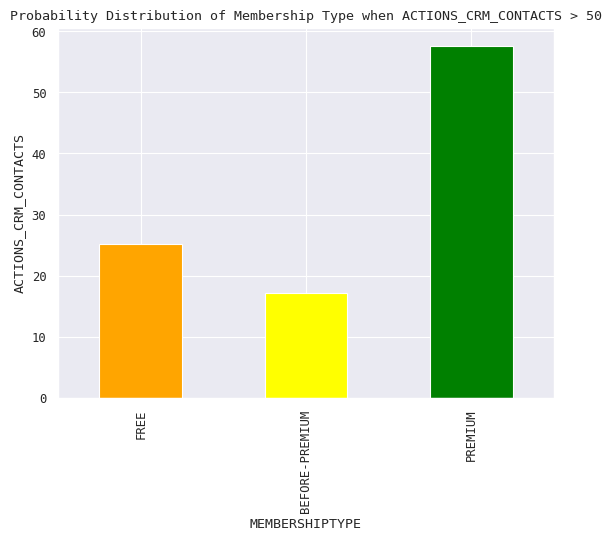

In [19]:
util.activity_vs_membership_plot(all_activity_df[all_activity_df['ACTIONS_CRM_CONTACTS'] > 50], 
                                 'MEMBERSHIPTYPE',
                                'ACTIONS_CRM_CONTACTS', 
                                 'Probability Distribution of Membership Type when ACTIONS_CRM_CONTACTS > 50')

## Inference
* We can confirm that, as the values of `ACTIONS_CRM_CONTACTS` increases, the probability of the customer being a premium member increases.

## Analyzing `ACTIONS_CRM_COMPANIES` column

In [21]:
(all_activity_df['ACTIONS_CRM_COMPANIES']).value_counts()

0.0       136563
1.0         1330
2.0          727
3.0          473
4.0          357
           ...  
1007.0         1
987.0          1
1489.0         1
1646.0         1
348.0          1
Name: ACTIONS_CRM_COMPANIES, Length: 587, dtype: int64

* This column also has a large number of values that are 0s. Let us see how the probability of becoming a PAID customer varies with this column

### When ACTIONS_CRM_COMPANIES = 0, how the MEMBERSHIPTYPE varies?

FREE              95.131917
BEFORE-PREMIUM     1.999077
PREMIUM            2.869006
Name: MEMBERSHIPTYPE, dtype: float64


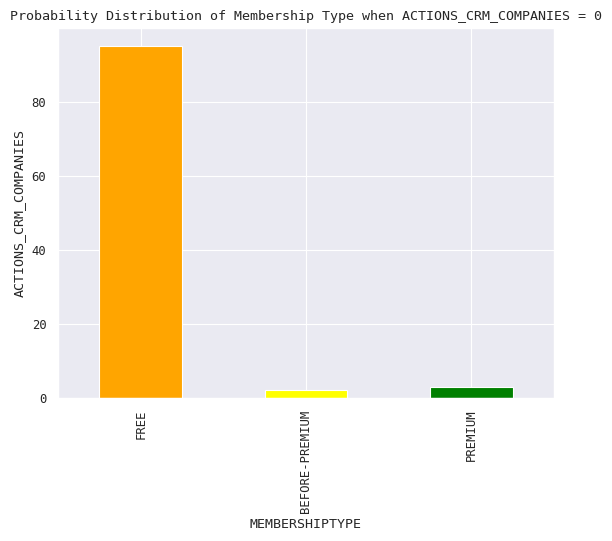

In [20]:
util.activity_vs_membership_plot(all_activity_df[all_activity_df['ACTIONS_CRM_COMPANIES'] == 0], 
                                 'MEMBERSHIPTYPE',
                                'ACTIONS_CRM_COMPANIES', 
                                 'Probability Distribution of Membership Type when ACTIONS_CRM_COMPANIES = 0')

### Inference
There is 95% probability that a customer is a FREE tier member if his activity involves 0 value for `ACTIONS_CRM_COMPANIES`

### When ACTIONS_CRM_COMPANIES > 50, how the MEMBERSHIPTYPE varies?

FREE              20.833333
BEFORE-PREMIUM    15.236318
PREMIUM           63.930348
Name: MEMBERSHIPTYPE, dtype: float64


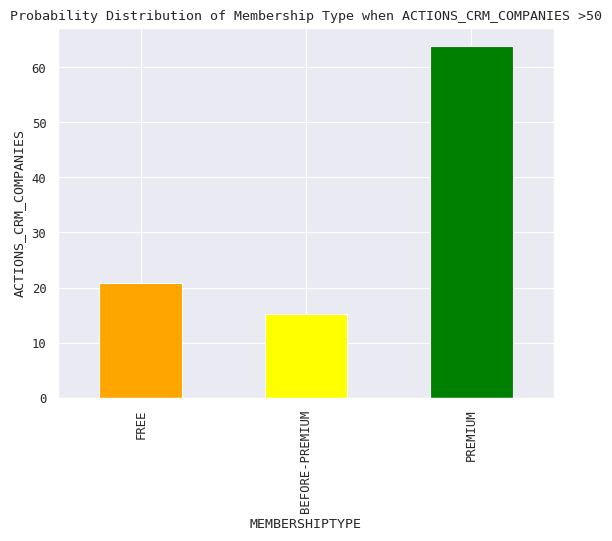

In [21]:
util.activity_vs_membership_plot(all_activity_df[all_activity_df['ACTIONS_CRM_COMPANIES'] > 50], 
                                 'MEMBERSHIPTYPE',
                                'ACTIONS_CRM_COMPANIES', 
                                 'Probability Distribution of Membership Type when ACTIONS_CRM_COMPANIES >50')

### Inference
* The `ACTIONS_CRM_COMPANIES` is also an important column to identify paid customer vs free customer activity

## Conducting similar analysis for `ACTIONS_CRM_DEALS`, `ACTIONS_EMAIL`

In [26]:
all_activity_df['ACTIONS_CRM_DEALS'].value_counts()

0.0       136217
1.0          846
2.0          557
3.0          417
5.0          311
           ...  
2957.0         1
5746.0         1
368.0          1
5763.0         1
404.0          1
Name: ACTIONS_CRM_DEALS, Length: 652, dtype: int64

FREE              95.542407
BEFORE-PREMIUM     1.879354
PREMIUM            2.578239
Name: MEMBERSHIPTYPE, dtype: float64


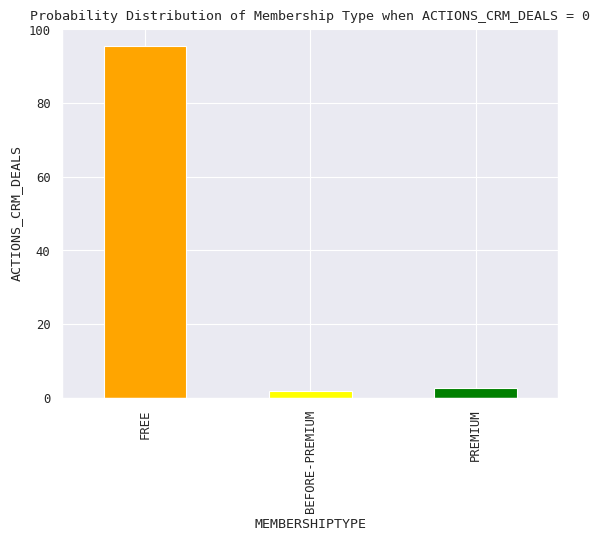

In [22]:
util.activity_vs_membership_plot(all_activity_df[all_activity_df['ACTIONS_CRM_DEALS'] == 0], 
                                 'MEMBERSHIPTYPE',
                                'ACTIONS_CRM_DEALS', 
                                 'Probability Distribution of Membership Type when ACTIONS_CRM_DEALS = 0')

FREE              13.695198
BEFORE-PREMIUM    15.198330
PREMIUM           71.106472
Name: MEMBERSHIPTYPE, dtype: float64


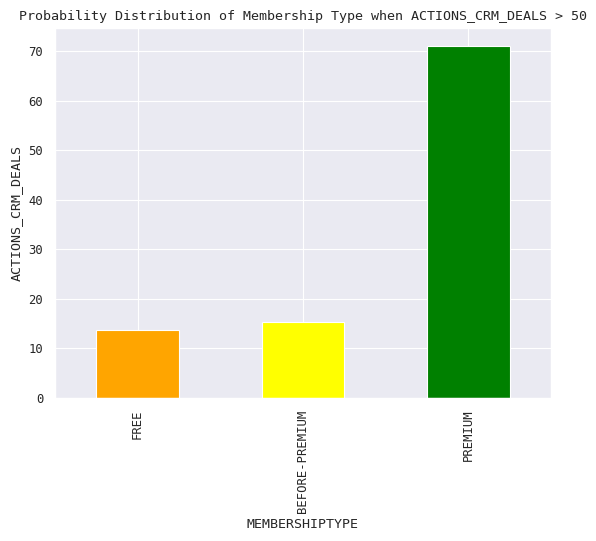

In [23]:
util.activity_vs_membership_plot(all_activity_df[all_activity_df['ACTIONS_CRM_DEALS'] > 50], 
                                 'MEMBERSHIPTYPE',
                                'ACTIONS_CRM_DEALS', 
                                 'Probability Distribution of Membership Type when ACTIONS_CRM_DEALS > 50')

In [28]:
all_activity_df['ACTIONS_EMAIL'].value_counts()

0.0      140925
1.0         897
2.0         507
3.0         352
4.0         276
          ...  
98.0          1
87.0          1
135.0         1
107.0         1
170.0         1
Name: ACTIONS_EMAIL, Length: 91, dtype: int64

FREE              94.064219
BEFORE-PREMIUM     2.160014
PREMIUM            3.775767
Name: MEMBERSHIPTYPE, dtype: float64


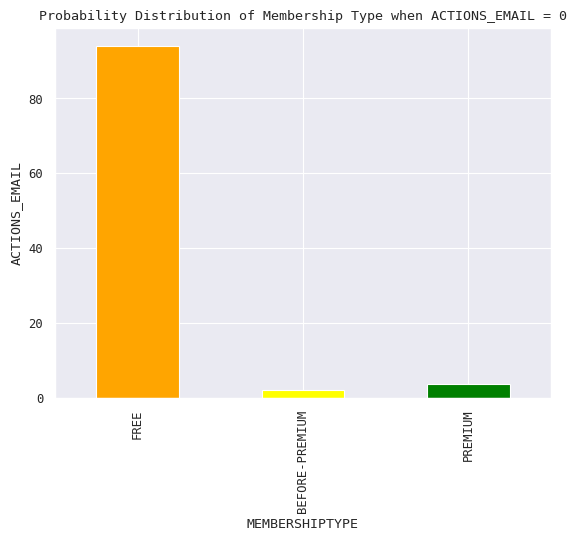

In [24]:
util.activity_vs_membership_plot(all_activity_df[all_activity_df['ACTIONS_EMAIL'] == 0], 
                                 'MEMBERSHIPTYPE',
                                'ACTIONS_EMAIL', 
                                 'Probability Distribution of Membership Type when ACTIONS_EMAIL = 0')

FREE               2.531646
BEFORE-PREMIUM    41.772152
PREMIUM           55.696203
Name: MEMBERSHIPTYPE, dtype: float64


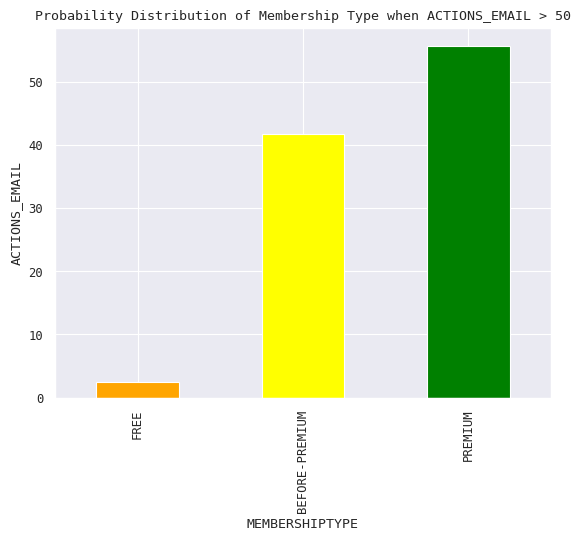

In [25]:
util.activity_vs_membership_plot(all_activity_df[all_activity_df['ACTIONS_EMAIL'] > 50], 
                                 'MEMBERSHIPTYPE',
                                'ACTIONS_EMAIL', 
                                 'Probability Distribution of Membership Type when ACTIONS_EMAIL > 50')

### Inference
* Clearly the `ACTIONS_EMAIL` and `ACTIONS_CRM_DEALS` play a very important role in identifying the paid customer activity vs free customer activity.

## How does the recency of using the system varies between paid and free members?

For each customer, the `LASTUSED` column contains the number of days the system was last used.Let us analyze how this column is related to `MEMBERSHIPTYPE`

In [29]:
all_activity_df['LASTUSED'].value_counts()

0      25390
7       9092
14      5879
21      4848
28      4375
       ...  
539       37
546       28
553       24
560       15
567        4
Name: LASTUSED, Length: 82, dtype: int64

### When `LASTUSED=0` how would the probability distribution for `MEMBERSHIP` varies?

FREE              66.664041
BEFORE-PREMIUM    11.299724
PREMIUM           22.036235
Name: MEMBERSHIPTYPE, dtype: float64


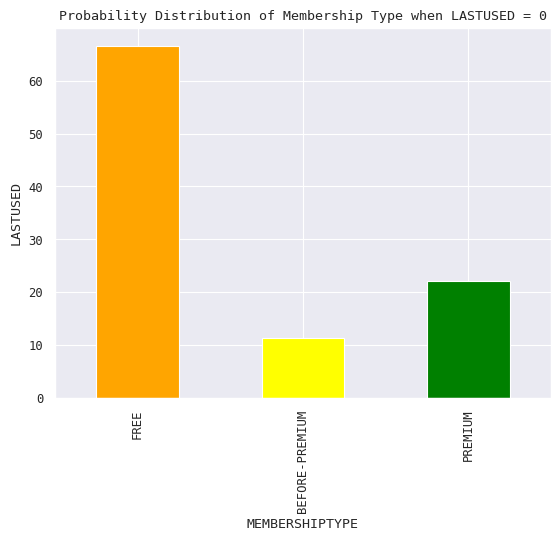

In [59]:
util.activity_vs_membership_plot(all_activity_df[all_activity_df['LASTUSED'] == 0], 
                                 'MEMBERSHIPTYPE',
                                'LASTUSED', 
                                 'Probability Distribution of Membership Type when LASTUSED = 0')

### Inference
* If the system is used frequently (at least once in a week), then there is a 22% chance that the activity belongs to a paid customer.

### When `LASTUSED = 7 Days` how would the probability distribution for `MEMBERSHIP` varies?

FREE              83.073031
BEFORE-PREMIUM     6.005279
PREMIUM           10.921689
Name: MEMBERSHIPTYPE, dtype: float64


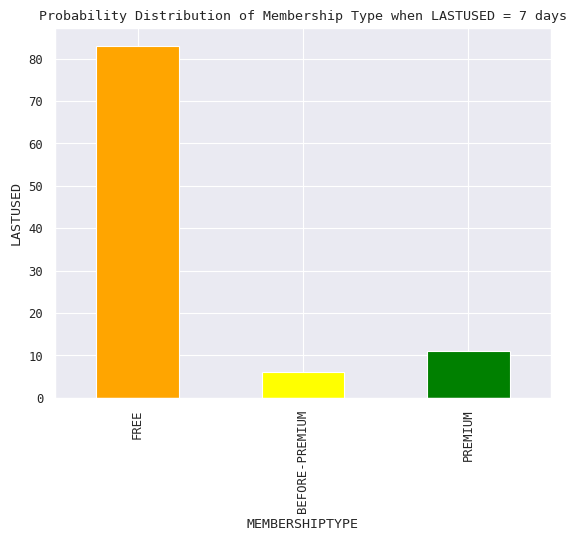

In [58]:
util.activity_vs_membership_plot(all_activity_df[all_activity_df['LASTUSED'] == 7], 
                                 'MEMBERSHIPTYPE',
                                'LASTUSED', 
                                 'Probability Distribution of Membership Type when LASTUSED = 7 days')

### When `LASTUSED = 14 Days` how would the probability distribution for `MEMBERSHIP` varies?

FREE              93.893519
BEFORE-PREMIUM     2.330328
PREMIUM            3.776152
Name: MEMBERSHIPTYPE, dtype: float64


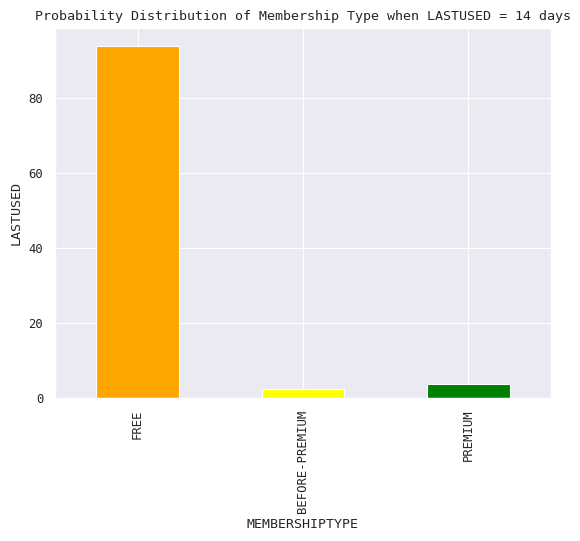

In [57]:
util.activity_vs_membership_plot(all_activity_df[all_activity_df['LASTUSED'] == 14], 
                                 'MEMBERSHIPTYPE',
                                'LASTUSED', 
                                 'Probability Distribution of Membership Type when LASTUSED = 14 days')

### When `LASTUSED = 21 Days` how would the probability distribution for `MEMBERSHIP` varies?

FREE              96.967822
BEFORE-PREMIUM     1.237624
PREMIUM            1.794554
Name: MEMBERSHIPTYPE, dtype: float64


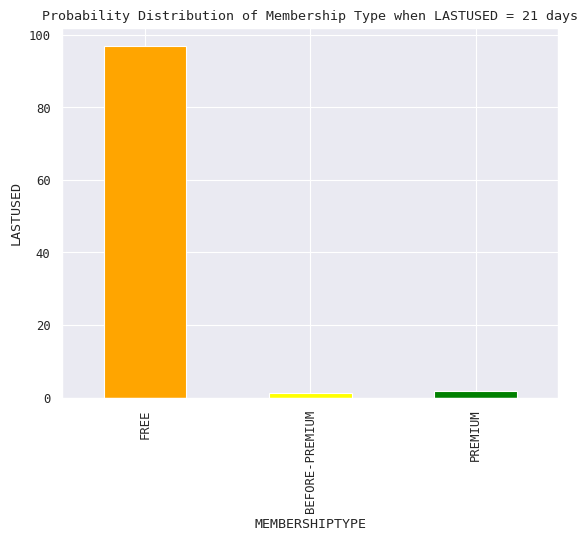

In [56]:
util.activity_vs_membership_plot(all_activity_df[all_activity_df['LASTUSED'] == 21], 
                                 'MEMBERSHIPTYPE',
                                'LASTUSED', 
                                 'Probability Distribution of Membership Type when LASTUSED = 21 days')

### Inference
* As the number of days since the system was last used increases, the probability of the inactivity belonging to a FREE member increases significantly. 
* If the last used days is more than 3 weeks, then there is only a 1% chance that the inactivity is from a paid customer.


## Analyzing `ALEXA_RANK`

<AxesSubplot: ylabel='Frequency'>

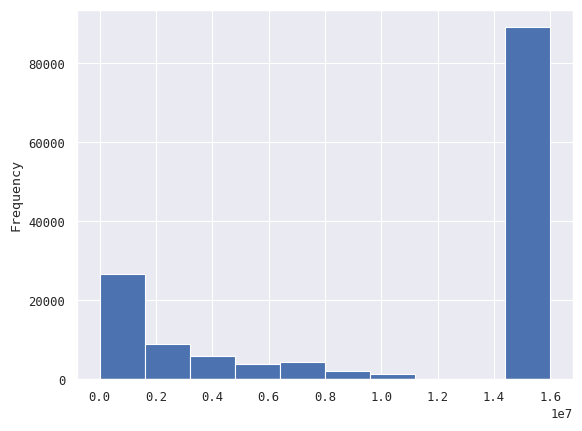

In [40]:
all_activity_df["ALEXA_RANK"].plot.hist()

In [41]:
all_activity_df["ALEXA_RANK"].value_counts()

16000001.0    89120
4639498.0       158
30684.0         152
558379.0        150
4393.0          143
              ...  
1787.0            1
3169605.0         1
13989.0           1
1154768.0         1
4284768.0         1
Name: ALEXA_RANK, Length: 1256, dtype: int64

### Inference
* Looks like the `ALEXA_RANK` column's NULL values are represented by `16000001`. 
* If we end up using this column in the model, we have to make sure that the nulls in this column are substituted with `16000001`
* Let us apply LOG on this column, and analyze how it varies with respect to `MEMBERSHIPTYPE`

In [50]:
alexa_cust_df = all_activity_df[['id', 'ALEXA_RANK', 'MEMBERSHIPTYPE']].drop_duplicates()
alexa_cust_df['LOG_ALEXA_RANK'] = np.log(alexa_cust_df["ALEXA_RANK"])
alexa_cust_df.head()

,id,ALEXA_RANK,MEMBERSHIPTYPE,LOG_ALEXA_RANK
0,199,309343.0,BEFORE-PREMIUM,12.642206
24,199,309343.0,PREMIUM,12.642206
82,147,16000001.0,BEFORE-PREMIUM,16.588099
93,147,16000001.0,PREMIUM,16.588099
163,118,60502.0,BEFORE-PREMIUM,11.010432


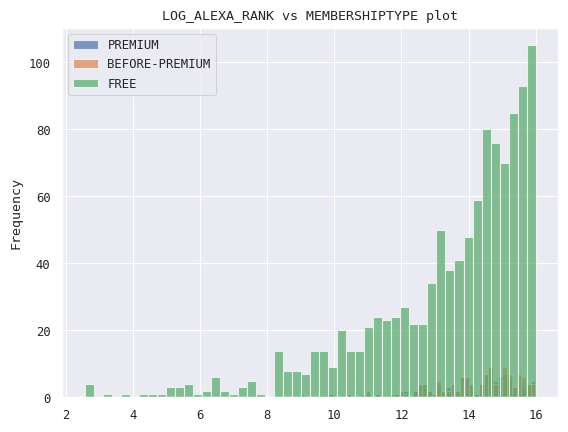

In [55]:
util.cat_to_num_plot(alexa_cust_df[alexa_cust_df['LOG_ALEXA_RANK'] < 16],
                    independent_var='LOG_ALEXA_RANK',
                    dependent_var='MEMBERSHIPTYPE',
                    title=None,
                    bins=50,
                    x_label=None,
                    y_label=None,
                    alpha=0.7,
                    figsize=(8, 6)
                    )

FREE              96.551724
BEFORE-PREMIUM     1.724138
PREMIUM            1.724138
Name: MEMBERSHIPTYPE, dtype: float64


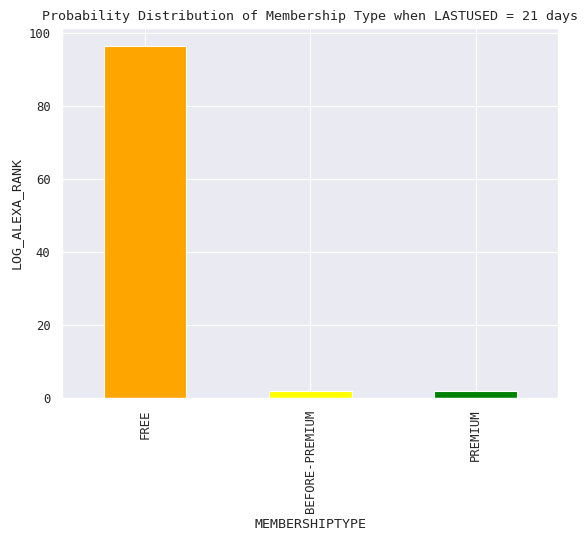

In [61]:
util.activity_vs_membership_plot(alexa_cust_df[alexa_cust_df['LOG_ALEXA_RANK'] <= 10], 
                                 'MEMBERSHIPTYPE',
                                'LOG_ALEXA_RANK', 
                                 'Probability Distribution of Membership Type when LASTUSED = 21 days')

FREE              92.673196
BEFORE-PREMIUM     3.699674
PREMIUM            3.627131
Name: MEMBERSHIPTYPE, dtype: float64


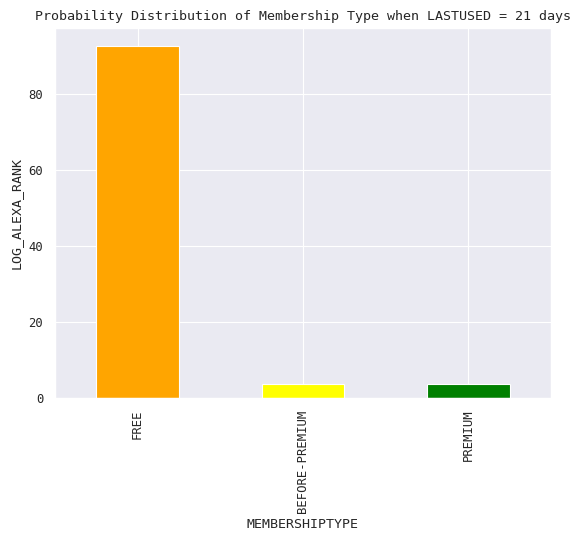

In [65]:
util.activity_vs_membership_plot(alexa_cust_df[alexa_cust_df['LOG_ALEXA_RANK'] >= 15], 
                                 'MEMBERSHIPTYPE',
                                'LOG_ALEXA_RANK', 
                                 'Probability Distribution of Membership Type when LASTUSED = 21 days')

### Inference
* The `ALEXA_RANK` is not much useful to identify the activity belonging to paid vs free customers, since the `MEMBERSHIPTYPE` probability distribution is uneffected with different ranges of `ALEXA_RANK` values. 
* Hence ignore `ALEXA_RANK`

### Analyzing Catagerocial Columns

In [6]:
util.get_cat_col_details(all_activity_df)

The data frame contains 144448 rows and 16 rows.
Out of 16 rows, 4 are categorical columns.
Here is the summary of categorical columns:
--------------------------------------------------------------------------------
Summary of "EMPLOYEE_RANGE":

The categorical variable: EMPLOYEE_RANGE contains 10 distinct values
It contains 9.9129% of nulls
It contains 99.99307709348693% of duplicate values

--------------------------------------------------------------------------------
Summary of "INDUSTRY":

The categorical variable: INDUSTRY contains 147 distinct values
It contains 73.7553% of nulls
It contains 99.89823327425786% of duplicate values

--------------------------------------------------------------------------------
Summary of "DATE":

The categorical variable: DATE contains 82 distinct values
It contains 0.0% of nulls
It contains 99.94323216659282% of duplicate values

--------------------------------------------------------------------------------
Summary of "MEMBERSHIPTYPE":

The

### Inference
* Let us ignore the `INDUSTRY` coulmn from further analysis, since it contains around 74% Nulls
* `ALEXA_RANK` and `EMPLOYEE_RANGE` columns also contain some null values.

In [67]:
all_activity_df['EMPLOYEE_RANGE'].value_counts()

2 to 5            30630
6 to 10           29011
26 to 50          16656
1                 14223
51 to 200         11608
11 to 25          10650
201 to 1000        8442
1001 to 10000      7817
10,001 or more     1092
Name: EMPLOYEE_RANGE, dtype: int64